<a href="https://colab.research.google.com/github/SambhavDeev/Translator_Eng_to_hin/blob/main/Translator_Seq2Seq_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://medium.com/analytics-vidhya/neural-machine-translation-using-simple-seq2seq-517b5ce1ae0f

In [ ]:
!pip install matplotlib-venn

In [ ]:
!apt-get -qq install -y libfluidsynth1

E: Package 'libfluidsynth1' has no installation candidate


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
import string
from string import digits
import re
from sklearn.utils import shuffle
from keras.preprocessing.sequence import pad_sequences
from keras.layers import LSTM, Input, Dense,Embedding
from keras.models import Model,load_model
#from keras.utils import plot_model
from keras.preprocessing.text import one_hot
from keras.preprocessing.text import Tokenizer
from keras.models import model_from_json
import pickle as pkl
import numpy as np

In [ ]:
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop
!pip install tensorflow==2.8
import tensorflow as tf

In [ ]:
with open('hin.txt','r') as f:
  data = f.read()
len(data)

185228

In [ ]:
# Split the data into lines
uncleaned_data_list = data.split('\n')

# Initialize lists to store English and Hindi words
english_words = []
hindi_words = []

# Iterate through each line in the data
for line in uncleaned_data_list:
    # Split each line by '\t' to separate English and Hindi words
    words = line.split('\t')

    # Ensure that the line is not empty and contains both English and Hindi words
    if len(words) == 2:
        english_words.append(words[0])
        hindi_words.append(words[1])

# Print the lengths of English and Hindi word lists
print(len(english_words), len(hindi_words))


2867 2867


In [ ]:

language_data = pd.DataFrame(columns=['English','Hindi'])
language_data['English'] = english_words
language_data['Hindi'] = hindi_words

# saving to csv
language_data.to_csv('language_data.csv', index=False)

# loading data from csv
language_data = pd.read_csv('language_data.csv')

In [ ]:
language_data.head()

,English,Hindi
0,Wow!,वाह!
1,Help!,बचाओ!
2,Jump.,उछलो.
3,Jump.,कूदो.
4,Jump.,छलांग.


In [ ]:
language_data.tail()

,English,Hindi
2862,The passengers who were injured in the acciden...,जिन यात्रियों को दुर्घटना मे चोट आई थी उन्हे अ...
2863,"Democracy is the worst form of government, exc...","लोकतंत्र सरकार का सबसे घिनौना रूप है, अगर बाकी..."
2864,If my boy had not been killed in the traffic a...,अगर मेरा बेटा ट्रेफ़िक हादसे में नहीं मारा गया...
2865,"When I was a kid, touching bugs didn't bother ...","जब मैं बच्चा था, मुझे कीड़ों को छूने से कोई पर..."
2866,Make a good translation of the sentence that y...,"आप जिस वाक्य का अनुवाद कर रहे हैं, उस ही का अच..."


In [ ]:
english_text = language_data['English'].values
hindi_text = language_data['Hindi'].values

english_text[0], hindi_text[0]

#lowercasing the setences
english_text_ = [x.lower() for x in english_text]
hindi_text_ = [x.lower() for x in hindi_text]

# Text preprocessing
english_text_ = [re.sub("'",'',x) for x in english_text_]
hindi_text_ = [re.sub("'",'',x) for x in hindi_text_]

# remove puntuation
def remove_punc(text_list):
  table = str.maketrans('', '', string.punctuation)
  removed_punc_text = []
  for sent in text_list:
    sentance = [w.translate(table) for w in sent.split(' ')]
    removed_punc_text.append(' '.join(sentance))
  return removed_punc_text
english_text_ = remove_punc(english_text_)
hindi_text_ = remove_punc(hindi_text_)

# removing the digits from english sentances
remove_digits = str.maketrans('', '', digits)
removed_digits_text = []
for sent in english_text_:
  sentance = [w.translate(remove_digits) for w in sent.split(' ')]
  removed_digits_text.append(' '.join(sentance))
english_text_ = removed_digits_text

# removing the digits from the marathi sentances
hindi_text_ = [re.sub("[२३०८१५७९४६]","",x) for x in hindi_text_]
hindi_text_ = [re.sub("[\u200d]","",x) for x in hindi_text_]

# removing the stating and ending whitespaces
english_text_ = [x.strip() for x in english_text_]
hindi_text_ = [x.strip() for x in hindi_text_]

In [ ]:
# Putting the start and end words in the hindi sentances
hindi_text_ = ["start " + x + " end" for x in hindi_text_]

In [ ]:
X = english_text_
Y = hindi_text_

#Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X,Y,test_size = 0.1)

print(len(X_train))

print(len(y_train))

print(len(X_test))

print(len(y_test))

2580
2580
287
287


In [ ]:
def generator_batch(X= X_train,Y=y_train, batch_size=128):
  while True:
    for j in range(0, len(X), batch_size):
      encoder_data_input = np.zeros((batch_size,max_length_english),dtype='float32') #metrix of batch_size*max_length_english
      decoder_data_input = np.zeros((batch_size,max_lenght_hindi),dtype='float32') #metrix of batch_size*max_length_marathi
      decoder_target_input = np.zeros((batch_size,max_lenght_hindi,vocab_size_target),dtype='float32') # 3d array one hot encoder decoder target data
      for i, (input_text,target_text) in enumerate(zip(X[j:j+batch_size],Y[j:j+batch_size])):
        for t, word in enumerate(input_text.split()):
          encoder_data_input[i,t] = tokenizer_input.word_index[word] # Here we are storing the encoder
                                                                     #seq in row here padding is done automaticaly as
                                                                     #we have defined col as max_lenght
        for t, word in enumerate(target_text.split()):
          # if word == 'START_':
          #   word = 'start'
          # elif word == 'END_':
          #   word = 'end'
          decoder_data_input[i,t] = tokenizer_target.word_index[word] # same for the decoder sequence
          if t>0:
            decoder_target_input[i,t-1,tokenizer_target.word_index[word]] = 1 #target is one timestep ahead of decoder input because it does not have 'start tag'
      # print(encoder_data_input.shape())
      yield ([encoder_data_input,decoder_data_input],decoder_target_input)

In [ ]:
vocab_size_input = len(english_text_)
vocab_size_target = len(hindi_text_)

In [ ]:
latent_dim = 50
# Define an input sequence and process it.
encoder_inputs = Input(shape=(None,),name="encoder_inputs")
emb_layer_encoder = Embedding(vocab_size_input,latent_dim, mask_zero=True)(encoder_inputs)
encoder = LSTM(latent_dim, return_state=True)
encoder_outputs, state_h, state_c = encoder(emb_layer_encoder)
# We discard `encoder_outputs` and only keep the states.
encoder_states = [state_h, state_c]

# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,),name="decoder_inputs")
# We set up our decoder to return full output sequences,
# and to return internal states as well. We don't use the
# return states in the training model, but we will use them in inference.
emb_layer_decoder = Embedding(vocab_size_target,latent_dim, mask_zero=True)(decoder_inputs)
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(emb_layer_decoder, initial_state=encoder_states)
decoder_dense = Dense(vocab_size_target, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model that will turn
# `encoder_input_data` & `decoder_input_data` into `decoder_target_data`
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])


train_samples = len(X_train)
val_samples = len(X_test)

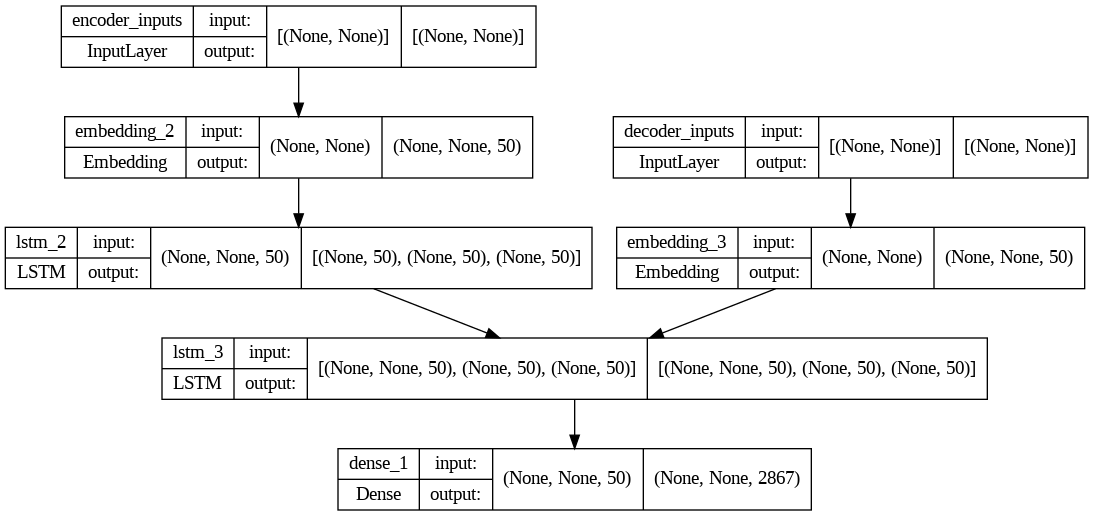

In [ ]:
!pip install tensorflow
!pip install pydot
!pip install graphviz

import tensorflow as tf
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='train_model.png', show_shapes=True)

In [ ]:
model_json = model.to_json()
with open("model_2.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model_weight_5.h5")
print("Saved model to disk")

# loading the model architecture and asigning the weights
json_file = open('model_2.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
model_loaded = model_from_json(loaded_model_json)
# load weights into new model
model_loaded.load_weights("model_weight_5.h5")

Saved model to disk


In [ ]:
latent_dim = 50
#inference encoder
encoder_inputs_inf = model_loaded.input[0] #Trained encoder input layer
encoder_outputs_inf, inf_state_h, inf_state_c = model_loaded.layers[4].output # retoring the encoder lstm output and states
encoder_inf_states = [inf_state_h,inf_state_c]
encoder_model = Model(encoder_inputs_inf,encoder_inf_states)


#inference decoder
# The following tensor will store the state of the previous timestep in the "starting the encoder final time step"
decoder_state_h_input = Input(shape=(latent_dim,)) #becase during training we have set the lstm unit to be of 50
decoder_state_c_input = Input(shape=(latent_dim,))
decoder_state_input = [decoder_state_h_input,decoder_state_c_input]

# # inference decoder input
decoder_input_inf = model_loaded.input[1] #Trained decoder input layer
# decoder_input_inf._name='decoder_input'
decoder_emb_inf = model_loaded.layers[3](decoder_input_inf)
decoder_lstm_inf = model_loaded.layers[5]
decoder_output_inf, decoder_state_h_inf, decoder_state_c_inf = decoder_lstm_inf(decoder_emb_inf, initial_state =decoder_state_input)
decoder_state_inf = [decoder_state_h_inf,decoder_state_c_inf]
#inference dense layer
dense_inf = model_loaded.layers[6]
decoder_output_final = dense_inf(decoder_output_inf)# A dense softmax layer to generate prob dist. over the target vocabulary

decoder_model = Model([decoder_input_inf]+decoder_state_input,[decoder_output_final]+decoder_state_inf)


In [ ]:
#inference decoder
# The following tensor will store the state of the previous timestep in the "starting the encoder final time step"
decoder_state_h_input = Input(shape=(latent_dim,)) #becase during training we have set the lstm unit to be of 50
decoder_state_c_input = Input(shape=(latent_dim,))
decoder_state_input = [decoder_state_h_input,decoder_state_c_input]

In [ ]:
# inference decoder input
decoder_input_inf = model_loaded.input[1] #Trained decoder input layer
# decoder_input_inf._name='decoder_input'
decoder_emb_inf = model_loaded.layers[3](decoder_input_inf)
decoder_lstm_inf = model_loaded.layers[5]
decoder_output_inf, decoder_state_h_inf, decoder_state_c_inf = decoder_lstm_inf(decoder_emb_inf, initial_state =decoder_state_input)
decoder_state_inf = [decoder_state_h_inf,decoder_state_c_inf]
#inference dense layer
dense_inf = model_loaded.layers[6]
decoder_output_final = dense_inf(decoder_output_inf)# A dense softmax layer to generate prob dist. over the target vocabulary

decoder_model = Model([decoder_input_inf]+decoder_state_input,[decoder_output_final]+decoder_state_inf)

In [ ]:

# Code to predct the input sentences translation
# def decode_seq(input_seq):
#   # print("input_seq=>",input_seq)
#   state_values_encoder = encoder_model.predict(input_seq)
#   # intialize the target seq with start tag
#   target_seq = np.zeros((1,1))
#   target_seq[0, 0] = tokenizer_target.word_index['start']
#   # print("target_seq:=>",target_seq)
#   stop_condition = False
#   decoder_sentance = ''
#   # print("Beforee the while loop")
#   while not stop_condition:
#     sample_word , decoder_h,decoder_c= decoder_model.predict([target_seq] + state_values_encoder)
#     # print("sample_word: =>",sample_word)
#     sample_word_index = np.argmax(sample_word[0,-1,:])
#     # print("sample_word_index: ",sample_word_index)
#     decoder_word = reverse_word_map_target[sample_word_index]
#     decoder_sentance += ' '+ decoder_word
#     # print("decoded word:=>",decoder_word)
#     # print(len(decoder_sentance))
#     # print("len(decoder_sentance) > 70: ",len(decoder_sentance) > 70)
#     # print('decoder_word == "end"',decoder_word == 'end')
#     # print(decoder_word == 'end' or len(decoder_sentance) > 70)
#     # stop condition for the while loop
#     if (decoder_word == 'end' or
#         len(decoder_sentance) > 70):
#         stop_condition = True
#         # print("from if condition")
#     # target_seq = np.zeros((1,1))
#     target_seq[0, 0] = sample_word_index
#     # print(target_seq)
#     state_values_encoder = [decoder_h,decoder_c]
#   return decoder_sentance

In [ ]:
# Code to predict the input sentences translation
def decode_seq(input_seq):
    state_values_encoder = encoder_model.predict(input_seq)
    # Initialize the target sequence with the start tag
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = tokenizer_target.word_index['start']
    stop_condition = False
    decoder_sentence = ''

    while not stop_condition:
        sample_word, decoder_h, decoder_c = decoder_model.predict([target_seq] + state_values_encoder)
        sample_word_index = np.argmax(sample_word[0, -1, :])

        # Check if the index exists in the reverse_word_map_target dictionary
        if sample_word_index in reverse_word_map_target:
            decoder_word = reverse_word_map_target[sample_word_index]
        else:
            decoder_word = 'UNKNOWN'  # Assign a placeholder for unknown words

        decoder_sentence += ' ' + decoder_word

        if decoder_word == 'end' or len(decoder_sentence) > 70:
            stop_condition = True

        # Update the target sequence for the next iteration
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sample_word_index

        # Update the state values for the next iteration
        state_values_encoder = [decoder_h, decoder_c]

    return decoder_sentence


In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer


In [ ]:
# Define tokenizer_input for English text
tokenizer_input = Tokenizer()
tokenizer_input.fit_on_texts(english_text_)
tokenizer_target = Tokenizer()


In [ ]:
tokenizer_target.fit_on_texts(y_train)

In [ ]:
# Reverse mapping for target language
reverse_word_map_target = dict(map(reversed, tokenizer_target.word_index.items()))


In [ ]:
print(reverse_word_map_target)


{1: 'start', 2: 'end', 3: 'है।', 4: 'में', 5: 'नहीं', 6: 'वह', 7: 'मैं', 8: 'से', 9: 'के', 10: 'है', 11: 'क्या', 12: 'मुझे', 13: 'को', 14: 'हैं।', 15: 'हो', 16: 'की', 17: 'बहुत', 18: 'उसने', 19: 'का', 20: 'तुम', 21: 'हूँ।', 22: 'यह', 23: 'पर', 24: 'एक', 25: 'था।', 26: 'लिए', 27: 'कर', 28: 'मेरे', 29: 'कि', 30: 'और', 31: 'हैं', 32: 'इस', 33: 'उसे', 34: 'भी', 35: 'मैंने', 36: 'मेरी', 37: 'रहा', 38: 'अपने', 39: 'पास', 40: 'ने', 41: 'करने', 42: 'अपनी', 43: 'ही', 44: 'हम', 45: 'कल', 46: 'तो', 47: 'गया।', 48: 'कोई', 49: 'उसकी', 50: 'उसके', 51: 'तुम्हारे', 52: 'काम', 53: 'तुम्हें', 54: 'उस', 55: 'था', 56: 'साथ', 57: 'मेरा', 58: 'घर', 59: 'सकते', 60: 'बात', 61: 'गया', 62: 'करना', 63: 'थी।', 64: 'पता', 65: 'समय', 66: 'रही', 67: 'कुछ', 68: 'उसको', 69: 'आप', 70: 'बजे', 71: 'यहाँ', 72: 'आज', 73: 'तुम्हे', 74: 'तक', 75: 'मुझसे', 76: 'किताब', 77: 'सकता', 78: 'चाहिए।', 79: 'लगता', 80: 'पसंद', 81: 'हूँ', 82: 'रहे', 83: 'थे।', 84: 'दिया।', 85: 'टॉम', 86: 'अपना', 87: 'अच्छा', 88: 'मत', 89: 'अभी', 90: 'आ

In [ ]:
for i in range(30):
  sentance = X_test[i]
  original_target = y_test[i]
  input_seq = tokenizer_input.texts_to_sequences([sentance])
  pad_sequence = pad_sequences(input_seq, maxlen= 30,padding='post')
  predicted_target = decode_seq(pad_sequence)
  print("Test sentance: ",i+1)
  print("sentance: ",sentance)
  print("origianl translate:",original_target[6:-4])
  print("predicted Translate:",predicted_target[:-4])
  print("=="*50)

Test sentance:  1
sentance:  the lake is deep here
origianl translate: झील यहाँ पर बहुत गहरी है।
predicted Translate:  दिशा एकदम जिन होगे उसका विदेशी फिर पर्स UNKNOWN मशहूर सुबह अभिमानी 
Test sentance:  2
sentance:  would you just move along a bit please
origianl translate: आप थोड़ा आगे खिसक सकते हैं क्या
predicted Translate:  चियर्स देखे भूकम्प द्वीप खाता बचाओ खेलना खेलना कह लेखक सोचना लिखकर सदस
Test sentance:  3
sentance:  we should do away with the death penalty
origianl translate: हमें मौत की सज़ा को हटा देना चाहिए।
predicted Translate:  गर्मियाँ काश सुरक्षित चुना। पहचानते पहचानते दुःखी खुशकिसमत दुःखी गिरफ़
Test sentance:  4
sentance:  this car has been used for the past ten years
origianl translate: इस गाड़ी का पिछले दस साल से इस्तेमाल हो रहा है।
predicted Translate:  अध्यापक कार्यक्रम बोलना बिस्तर बौद्ध खालूँ। आराम नमस्ते। नमस्ते। नमस
Test sentance:  5
sentance:  it is said that women live longer than men
origianl translate: कहा जाता है कि औरतों की उम्र आदमियों से ज़्यादा लम्बी ह